# Notebook for regression
6th Apr

Refactored notebook for training random forest models with morgan fingerprints or MPNN hidden state vectors

Let's load the moonshot data first

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import MolFromSmiles, MolToSmiles

def canon_tautomers(smiles_list):
    enumerator = rdMolStandardize.TautomerEnumerator()

    smiles_list = [MolToSmiles(enumerator.Canonicalize(
        MolFromSmiles(smi))) for smi in smiles_list]

    return smiles_list


def read_and_process_dataframe(path_to_dataframe, canonicalize_tautomers=True, IC50_threshold=None, pIC50_threshold=None):
    df = pd.read_csv(path_to_dataframe)

    if canonicalize_tautomers:
        df['SMILES'] = canon_tautomers(df['SMILES']) 

    # assign IC50 of 100 to inactives
    df.loc[df['IC50'].astype(str).str.contains('>'), 'IC50'] = 100.0
    df.loc[df['IC50'].isnull(), 'IC50'] = 100.0
    
    df['IC50'] = df['IC50'].astype(float)
    df['pIC50'] = -np.log10(df['IC50'].to_numpy()) + 6

    indicies_of_actives = df[df['IC50'] != 100.0].index.to_numpy()
    
    if IC50_threshold is not None:
        df = df.query('IC50 < @IC50_threshold')
    if pIC50_threshold is not None:
        df = df.query('pIC50 >= @pIC50_threshold')

    pIC50_values = df['pIC50'].to_numpy()

    return df, pIC50_values, indicies_of_actives

moonshot_data_dir = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/moonshot_evaluation_sets/'
file_names = ['combined_acid.csv', 'combined_aldehyde.csv', 'combined_amine.csv', 'combined_isocyanide.csv']
file_names = [f'{moonshot_data_dir}{file}' for file in file_names]

list_of_dataframes = []
list_of_pIC50_values = []
list_of_active_indices = []

for file in file_names:

    df_for_this_file, y_train, indicies_of_actives = read_and_process_dataframe(file)

    list_of_dataframes.append(df_for_this_file)
    list_of_pIC50_values.append(y_train)
    list_of_active_indices.append(indicies_of_actives)


INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions
RDKit WARNING: [16:32:35] Tautomer enumeration stopped at 207 tautomers: max transforms reached
[16:32:35] Tautomer enumeration stopped at 207 tautomers: max transforms reached
RDKit WARNING: [16:32:38] Tautomer enumeration stopped at 229 tautomers: max transforms reached
[16:32:38] Tautomer enumeration stopped at 229 tautomers: max transforms reached


Generate fingerprints

In [2]:
from useful_rdkit_utils import add_molecule_and_errors, mol2numpy_fp
from dock2hit.generate_mpnn_fps import generate_mpnn_fps_from_dataframe

taut_model='/rds-d2/user/wjm41/hpc-work/models/dock2hit/ugi/ugi_taut/model_mol9039221.ckpt'
old_model = '/rds-d2/user/wjm41/hpc-work/models/dock2hit/ugi/ugi_full/model_mol4608000.ckpt'

for df in list_of_dataframes:
    add_molecule_and_errors(df, mol_col_name='mol')
    df['morgan_fp'] = df['mol'].apply(mol2numpy_fp)
    df['mpnn_fp'] = [x for x in generate_mpnn_fps_from_dataframe(df, load_name=taut_model)]

INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
  0%|          | 0/1 [00:02<?, ?it/s]


Visualise IC50

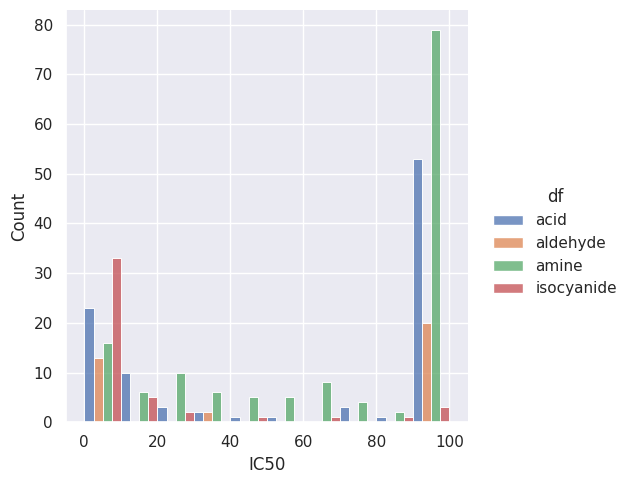

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.dpi":100})

names = ['acid', 'aldehyde', 'amine', 'isocyanide']
for i,df in enumerate(list_of_dataframes):
    df['df'] = names[i]

df_all = pd.concat(list_of_dataframes).reset_index()
df_all['IC50'] = df_all['IC50'].astype(float)

sns.displot(data = df_all, x="IC50", hue="df", multiple="dodge", bins=10)

plt.show()

# Model Comparison

### Useful functions

In [5]:
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import RepeatedKFold

from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler


def enrichment(y_true, y_pred, n=100, threshold=6, log=False):
    
    y_true = np.where(y_true>threshold, 1, 0) # replace pIC50s with binary labels
    orig_prop = np.sum(y_true)/len(y_true)
    best_n_inds = np.argsort(y_pred)[-n:][::-1]
    sorted_preds = y_true[best_n_inds] # pick predicted best n
    new_prop = np.sum(sorted_preds)/len(sorted_preds)
    if log:
        print('orig proportion of actives: {:.3f}%'.format(orig_prop*100))
        print('new proportion of actives: {:.3f}%'.format(new_prop*100))
    EF = new_prop/orig_prop

    return EF

  
def calc_metrics(model, model_name, X_train, y_train, X_test, y_test, test_inds):
    train_preds = model.predict(X_train)

    r2_train = r2_score(y_train,train_preds)
    rho_train = spearmanr(y_train, train_preds)[0]
    rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
    
    test_preds = model.predict(X_test)

    r2_test = r2_score(y_test[test_inds], test_preds[test_inds])
    rho_test = spearmanr(y_test[test_inds], test_preds[test_inds])[0]
    rmse_test = np.sqrt(mean_squared_error(y_test[test_inds], test_preds[test_inds]))

    df_train = pd.DataFrame({'model': model_name,
                             'R2': r2_train,
                             'rho': rho_train,
                             'RMSE': rmse_train},
                             index=[0])
    df_test = pd.DataFrame({'model': model_name,
                             'R2': r2_test,
                             'rho': rho_test,
                            'RMSE': rmse_test},
                             index=[0])
                             
    return test_preds, df_train, df_test

def plot_comparison(y_test, test_inds, pred_list, model_names,  title, threshold=6):
    # Enrichment
    y_true = np.where(y_test>threshold, 1, 0) # replace pIC50s with binary labels

    orig_prop = np.sum(y_true)/len(y_true)
    n_list = np.logspace(start=np.log10(5), stop=min(2,np.log10(len(y_test))), num=20) # only check top 100

    EFs = []
    for preds in pred_list:
        EFs.append([enrichment(y_test, preds, n=int(n), threshold=threshold) for n in n_list]) 

    n = len(pred_list)
    if n == 2:
        color_list = ['#ef5675', '#003f5c']
        alpha_list = [0.6, 0.7]
        lw_list = [1.5, 1]
    if n == 3:
        color_list = ['#ef5675', '#7a5195', '#ffa600']
        alpha_list = [0.6, 0.7, 0.8]

        lw_list = [2, 1.5, 1]

    if n == 4:
        color_list = ['#ef5675', '#003f5c', '#7a5195', '#ffa600']
        alpha_list = [0.6, 0.7, 0.8, 0.9]
        marker_list = ['o', 'x', 's', '+']
        lw_list = [2.5, 2, 1.5, 1]

    with plt.style.context('seaborn-white'):
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, constrained_layout=True)
        axs[0].plot([np.amin(y_test), np.amax(y_test)], [np.amin(y_test), np.amax(y_test)], 'k:', lw=1)

        for n, preds in enumerate(pred_list):
            axs[0].scatter(y_test[test_inds], preds[test_inds], alpha=alpha_list[n], label=model_names[n], c=color_list[n], s=4, marker=marker_list[n], edgecolors='none')
            axs[1].plot(n_list, EFs[n], '-', alpha=alpha_list[n], label=model_names[n], color=color_list[n], lw=lw_list[n])
            
        axs[0].set_title('pIC50 Regression')
        axs[0].set_xlabel('Measured pIC50')
        axs[0].set_ylabel('Predicted pIC50\n(n={})'.format(len(y_test[test_inds])))

        axs[1].plot(n_list, np.ones_like(n_list), 'k:')
        axs[1].set_yticks(list(plt.yticks()[0]) + [1])
        axs[1].set_ylim(bottom=0)        
        axs[1].legend(prop={'size': 8}, facecolor='white', framealpha=1, frameon=True, loc='upper right')
        axs[1].set_title('Enrichment (pIC50 > {})\n(including inactives)'.format(threshold))  
        axs[1].set_xlabel('n')
        axs[1].set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    plt.suptitle(title)
    plt.show() 


## Run and Plot Model Comparison

{'n_estimators': 1485, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
{'n_estimators': 714, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}
{'n_estimators': 1265, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Training Set
                model        R2       rho      RMSE
     Canon MPNN FP RF  0.949401  0.932297  0.174408
     Canon MPNN FP GP  0.973241  0.950740  0.126832
 Old Enum. MPNN FP RF  0.908125  0.912736  0.235015
            Morgan RF  0.911462  0.926261  0.230707

Test Set
                model        R2       rho      RMSE
     Canon MPNN FP RF  0.475924  0.636608  0.585322
     Canon MPNN FP GP  0.516760  0.625743  0.562055
 Old Enum. MPNN FP RF  0.161426  0.659542  0.740403
            Morgan RF -0.573090  0.378576  1.014085


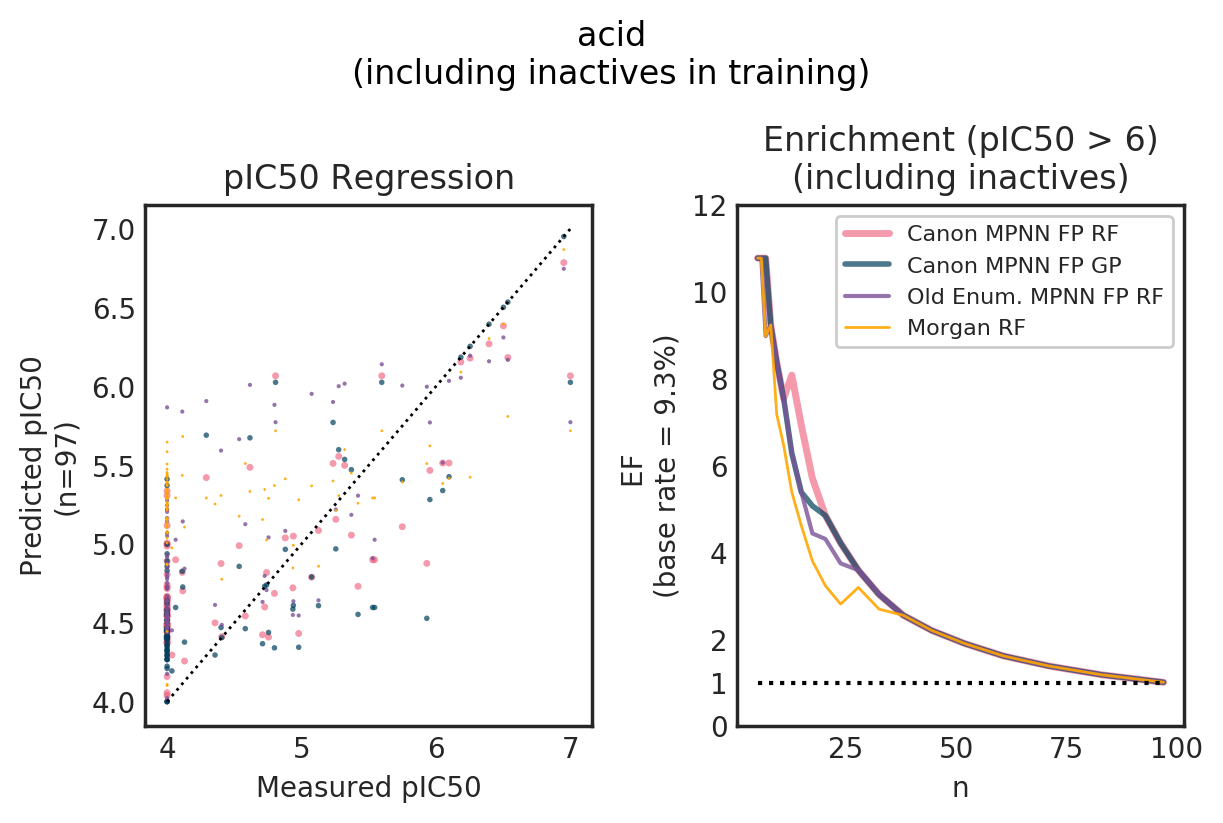

{'n_estimators': 1118, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
{'n_estimators': 1889, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}


In [38]:
model_names_2 = ['Canon MPNN FP RF', 'Canon MPNN FP GP']
model_names_3 = ['Canon MPNN FP RF', 'Old Enum. MPNN FP RF', 'Morgan RF']
model_names_4 = ['Canon MPNN FP RF', 'Canon MPNN FP GP', 'Old Enum. MPNN FP RF', 'Morgan RF']
split_names = ['acid', 'aldehyde', 'amines', 'isocyanide']
split_names_active = [x + '\n(only actives)' for x in split_names]
split_names_inactive = [x + '\n(including inactives in training)' for x in split_names]
threshold = 6 # pIC50 threshold for EF calculation

model_names = model_names_4

split_names = split_names_inactive
inactive = True

# test on inactives too!
test_inds_list = []
for x in xs_morgan_train:
    test_inds_list.append(range(len(x)))

# inactive = False
# split_names = split_names_active

for i, y_test in enumerate(ys):
    if not inactive:
        X_train_fps_old = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_old_train) if i!=j])
        X_train_fps_taut = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_taut_train) if i!=j])
        X_train_morgan_np = np.concatenate([x[test_inds_list[j]] for j,x in enumerate(xs_morgan_train) if i!=j])
        y_train = np.concatenate([y[test_inds_list[j]] for j,y in enumerate(ys) if i!=j])

    else:
        X_train_fps_old = np.concatenate([x for j,x in enumerate(xs_old_train) if i!=j])
        X_train_fps_taut = np.concatenate([x for j,x in enumerate(xs_taut_train) if i!=j])
        X_train_morgan_np = np.concatenate([x for j,x in enumerate(xs_morgan_train) if i!=j])
        y_train = np.concatenate([y for j,y in enumerate(ys) if i!=j])
        
    X_train = [X_train_fps_taut, X_train_fps_taut, X_train_fps_old, X_train_morgan_np]

    X_test_fps_old = xs_old_train[i]
    X_test_fps_taut = xs_taut_train[i]
    X_test_morgan_np = xs_morgan_train[i]
    X_test = [X_test_fps_taut, X_test_fps_taut, X_test_fps_old, X_test_morgan_np]

    rf_fps_old= fit_forest(X_train_fps_old, y_train.flatten(), uncertain=True)
    rf_fps_taut = fit_forest(X_train_fps_taut, y_train.flatten(), uncertain=True)
    rf_morgan = fit_forest(X_train_morgan_np, y_train.flatten(), uncertain = True)
    # gpr_taut = fit_gp(X_train_fps_taut, y_train.flatten())
    
    gpr_taut = GaussianProcessRegressor(alpha=1e-6, kernel=Matern(0.1, nu=0.5), normalize_y=True).fit(
        X_train_fps_taut, y_train.flatten())

    models = {'Canon MPNN FP RF': rf_fps_taut, 
              'Canon MPNN FP GP': gpr_taut, 
              'Old Enum. MPNN FP RF': rf_fps_old, 
              'Morgan RF': rf_morgan}

    models = [models[name] for name in model_names]

    pred_list = []
    train_dfs = []
    test_dfs = []
    for n, model in enumerate(models):
            test_pred, train_metrics, test_metrics = calc_metrics(model, model_names[n], # TODO indexing clash with dictionary
                                                                  X_train[n], y_train, 
                                                                  X_test[n], y_test, test_inds_list[i])
            pred_list.append(test_pred)
            train_dfs.append(train_metrics)
            test_dfs.append(test_metrics)

    df_train = pd.concat(train_dfs)
    print('Training Set')
    print(df_train.to_string(index=False))

    df_test = pd.concat(test_dfs)
    print('\nTest Set')
    print(df_test.to_string(index=False))
     
    plot_comparison(y_test, test_inds_list[i], pred_list, model_names, title=split_names[i])
    # compare_models(X_train_fps_old, X_train_fps_taut, X_train_morgan_np, y_train,
                #    X_test_fps_old, X_test_fps_taut, X_test_morgan_np,  y_test,
                #    title=split_names[i], threshold=threshold)

# old_train, old_test = train_test_split(np.concatenate(xs_old), random_state=42)
# taut_train, taut_test = train_test_split(np.concatenate(xs_taut), random_state=42)

# xs_morgan_fp = [fp_to_numpy(x) for fp in xs_morgan for x in fp ]
# x_morgan_train, x_morgan_test = train_test_split(xs_morgan_fp, random_state=42)

# y_train, y_test = train_test_split(np.concatenate(ys), random_state=42)

# compare_models(old_train, taut_train, x_morgan_train, y_train,
#               old_test, taut_test, x_morgan_test,  y_test,
#               title='random_all', threshold=threshold)


## Calibrating Uncertainties

### Training set

In [ ]:
inactive = True
split_names = ['acid', 'aldehyde', 'amines', 'isocyanide']
plt.style.use('seaborn-white')
cmap = plt.get_cmap("tab10")

def error_curve(y_test, y_pred, y_var, ax, name, color=0):
    n = len(y_test)-1

    errors = np.absolute(y_test-y_pred)

    RMSE_pred = np.zeros(n)
    RMSE_true = np.zeros(n)
    var_val = np.linspace(100, 0, n)
    x_max = np.sqrt(np.amax(y_var))
    x_min = np.sqrt(np.amin(y_var))
    y_pred_pred = y_pred
    y_pred_true = y_pred
    y_test_pred = y_test
    y_test_true = y_test
    for i in range(n):
            max_ind_pred = y_var.argmax()
            y_test_pred = np.delete(y_test_pred, max_ind_pred)
            y_pred_pred = np.delete(y_pred_pred, max_ind_pred, 0)
            RMSE_pred[i] = np.sqrt(mean_squared_error(y_test_pred, y_pred_pred))
            y_var = np.delete(y_var, max_ind_pred)

            max_ind_true = errors.argmax()
            y_test_true = np.delete(y_test_true, max_ind_true)
            y_pred_true = np.delete(y_pred_true, max_ind_true, 0)
            RMSE_true[i] = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
            errors = np.delete(errors, max_ind_true)

    num_dec = 0
    for i in range(len(RMSE_pred)):
    	if i != len(RMSE_pred)-1:
            if RMSE_pred[i] >= RMSE_pred[i+1]:
                num_dec += 1

    auco = np.sum(RMSE_pred-RMSE_true)
    errdrop = RMSE_pred[0]/RMSE_pred[-1]
    decrat = num_dec/len(RMSE_pred)

    ax.plot(var_val, RMSE_pred, linestyle='--', marker='o', color=color,
            markersize=1, label=name + ' - Predicted')
    ax.plot(var_val, RMSE_true, linestyle='dotted', marker='x', color=color,
            markersize=1, label=name + ' - True')
    ax.legend(loc='lower left')
    ax.set_xlabel('% data threshold by st_dev')
    ax.set_ylabel('RMSE')
    ax.set_title('Error Confidence Curves')
    return


for i, y_test in enumerate(ys):
    if not inactive:
        X_train_fps_taut = np.concatenate(
            [x[test_inds_list[j]] for j, x in enumerate(xs_taut_train) if i != j])
        X_train_morgan_np = np.concatenate(
            [x[test_inds_list[j]] for j, x in enumerate(xs_morgan_train) if i != j])
        y_train = np.concatenate([y[test_inds_list[j]]
                                 for j, y in enumerate(ys) if i != j])

    else:
        X_train_fps_taut = np.concatenate(
            [x for j, x in enumerate(xs_taut_train) if i != j])
        X_train_morgan_np = np.concatenate(
            [x for j, x in enumerate(xs_morgan_train) if i != j])
        y_train = np.concatenate([y for j, y in enumerate(ys) if i != j])

    X_train = [X_train_fps_taut, X_train_morgan_np]

    X_test_fps_taut = xs_taut_train[i]
    X_test_morgan_np = xs_morgan_train[i]
    # X_test = [X_test_fps_taut, X_test_morgan_np]
    X_test = [X_train_fps_taut, X_train_morgan_np]
    y_test = y_train

    rf_fps_taut = fit_forest(
        X_train_fps_taut, y_train.flatten(), uncertain=True)
    rf_morgan = fit_forest(
        X_train_morgan_np, y_train.flatten(), uncertain=True)

    preds_fps, var_fps = rf_fps_taut.predict(X_test_fps_taut, no_var=False)
    preds_fps, var_fps = rf_fps_taut.predict(X_train_fps_taut, no_var=False)
    # preds_morgan, var_morgan = rf_morgan.predict(
    #     X_test_morgan_np, no_var=False)

    # pred_list = [preds_fps, preds_morgan]
    # var_list = [var_fps, var_morgan]
    # model_names = ['FP RF', 'Morgan RF']
    pred_list = [preds_fps]
    var_list = [var_fps]
    model_names = ['FP RF']
    
    fig, axs = plt.subplots(figsize=(15, 8),
        nrows=1, ncols=3, dpi=200, constrained_layout=True)
    axs[0].plot([np.amin(y_test), np.amax(y_test)], [
                np.amin(y_test), np.amax(y_test)], 'k:', lw=1)

    for n, preds in enumerate(pred_list):
        axs[0].errorbar(y_test, preds, label=model_names[n], yerr=np.sqrt(var_list[n]), 
        linestyle='', marker='x', markersize=3, capsize=1, color=cmap(i))
        axs[1].hist(np.sqrt(var_list[n]), label=model_names[n],
                    density=True, alpha=0.7, histtype='barstacked', color=cmap(i))
        error_curve(y_test, preds, var_list[n], ax=axs[2], name=model_names[n], color=cmap(i)) 
    axs[2].invert_xaxis()
    axs[0].set_title('pIC50 Regression')
    axs[0].set_xlabel('Measured pIC50')
    axs[0].set_ylabel(
        'Predicted pIC50\n(n={})'.format(len(y_test)))
    axs[0].legend()

    axs[1].set_ylabel('Density')
    axs[1].set_xlabel('std_dev')
    plt.suptitle(split_names[i])
    plt.show()  

    df_train = pd.concat([df for j,df in enumerate(dfs_taut) if i!=j ])
    df_train['pred'] = preds_fps
    df_train['std'] = np.sqrt(var_fps)
    df_uncertain = df_train.nlargest(n=20, columns = 'std')
    mols = [MolFromSmiles(smi) for smi in df_uncertain['SMILES']]
    mcs = rdFMCS.FindMCS(mols)
    mcs_query = Chem.MolFromSmarts(mcs.smartsString)
    AllChem.Compute2DCoords(mcs_query)
    for m in mols:
        AllChem.GenerateDepictionMatching2DStructure(m, mcs_query)
    df_uncertain['mols'] = mols

    display(mols2grid.display(df_uncertain,
                             mol_col='mols',
                             smiles_col='SMILES',
                             subset=['img', 'pred',
                                     'std'],
                             transform={"pred": lambda x: f"y_pred: {x:.3f}",
                                        "std": lambda x: f"y_var: {x:.3f}"},
                             tooltip=["SMILES"],
                             useSVG=True,
                             use_coords=True,
                             selection=False,
                             n_rows=5,
                             size=(240, 260),
                             width='85%'))


### Test set

{'n_estimators': 493, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}


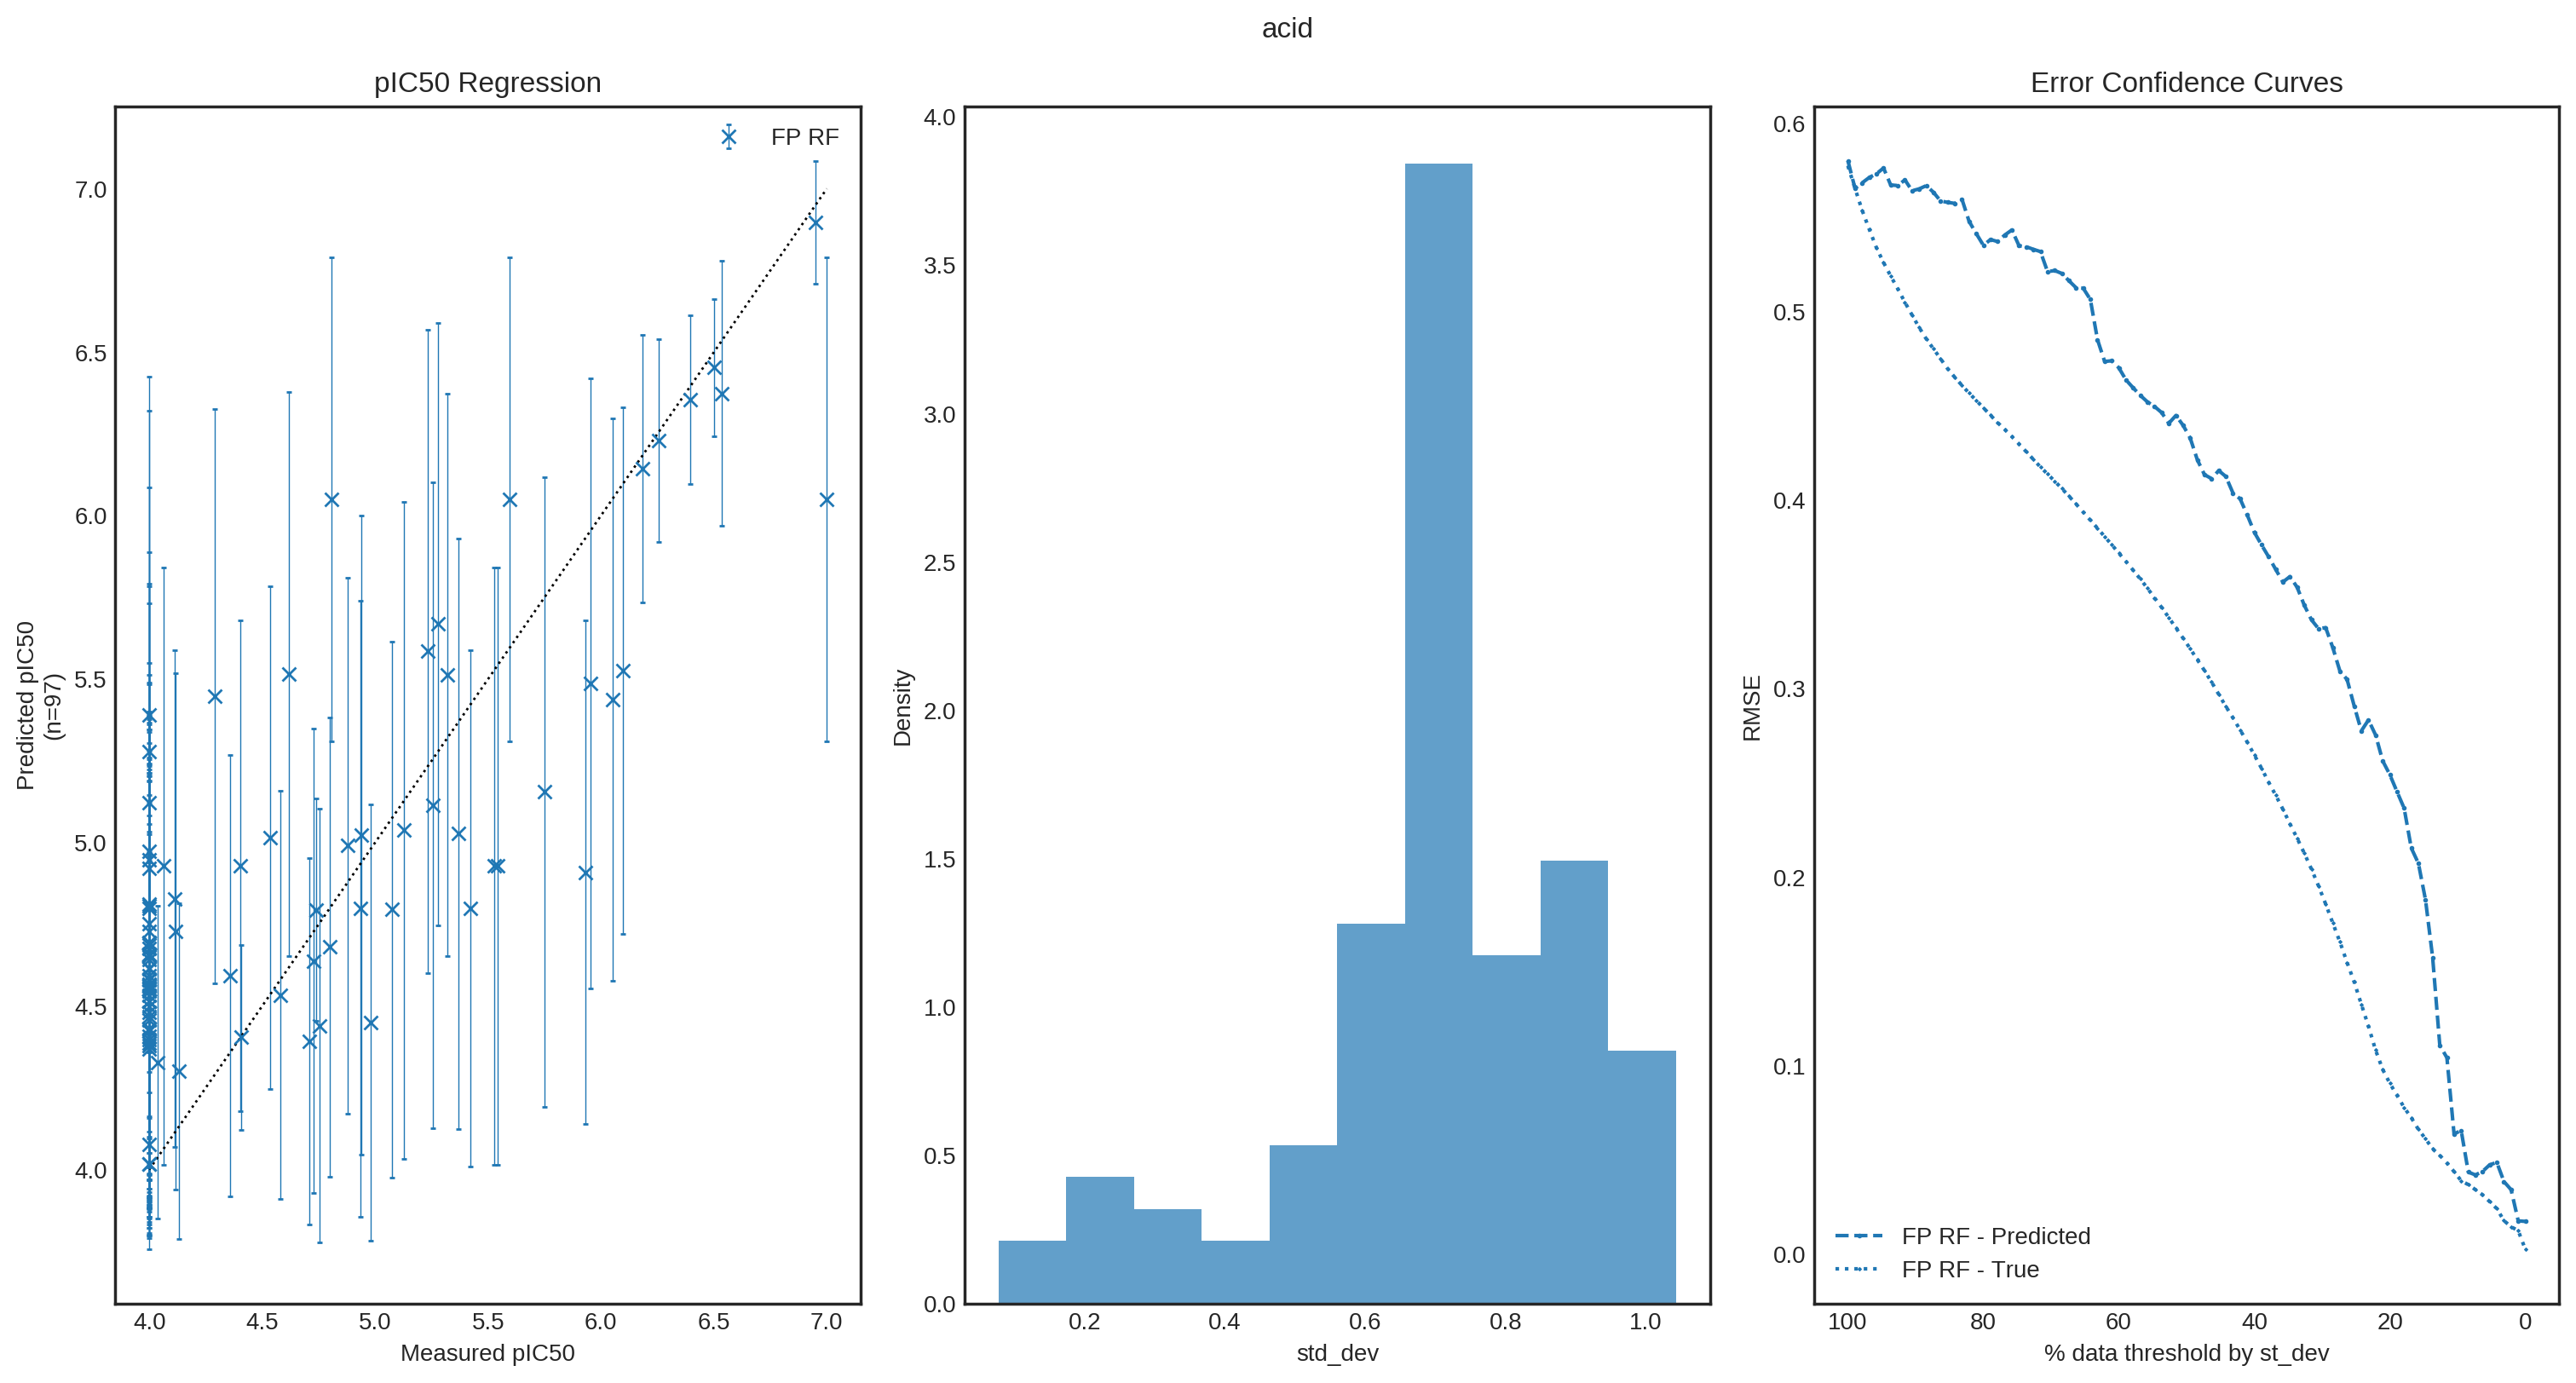

{'n_estimators': 1302, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


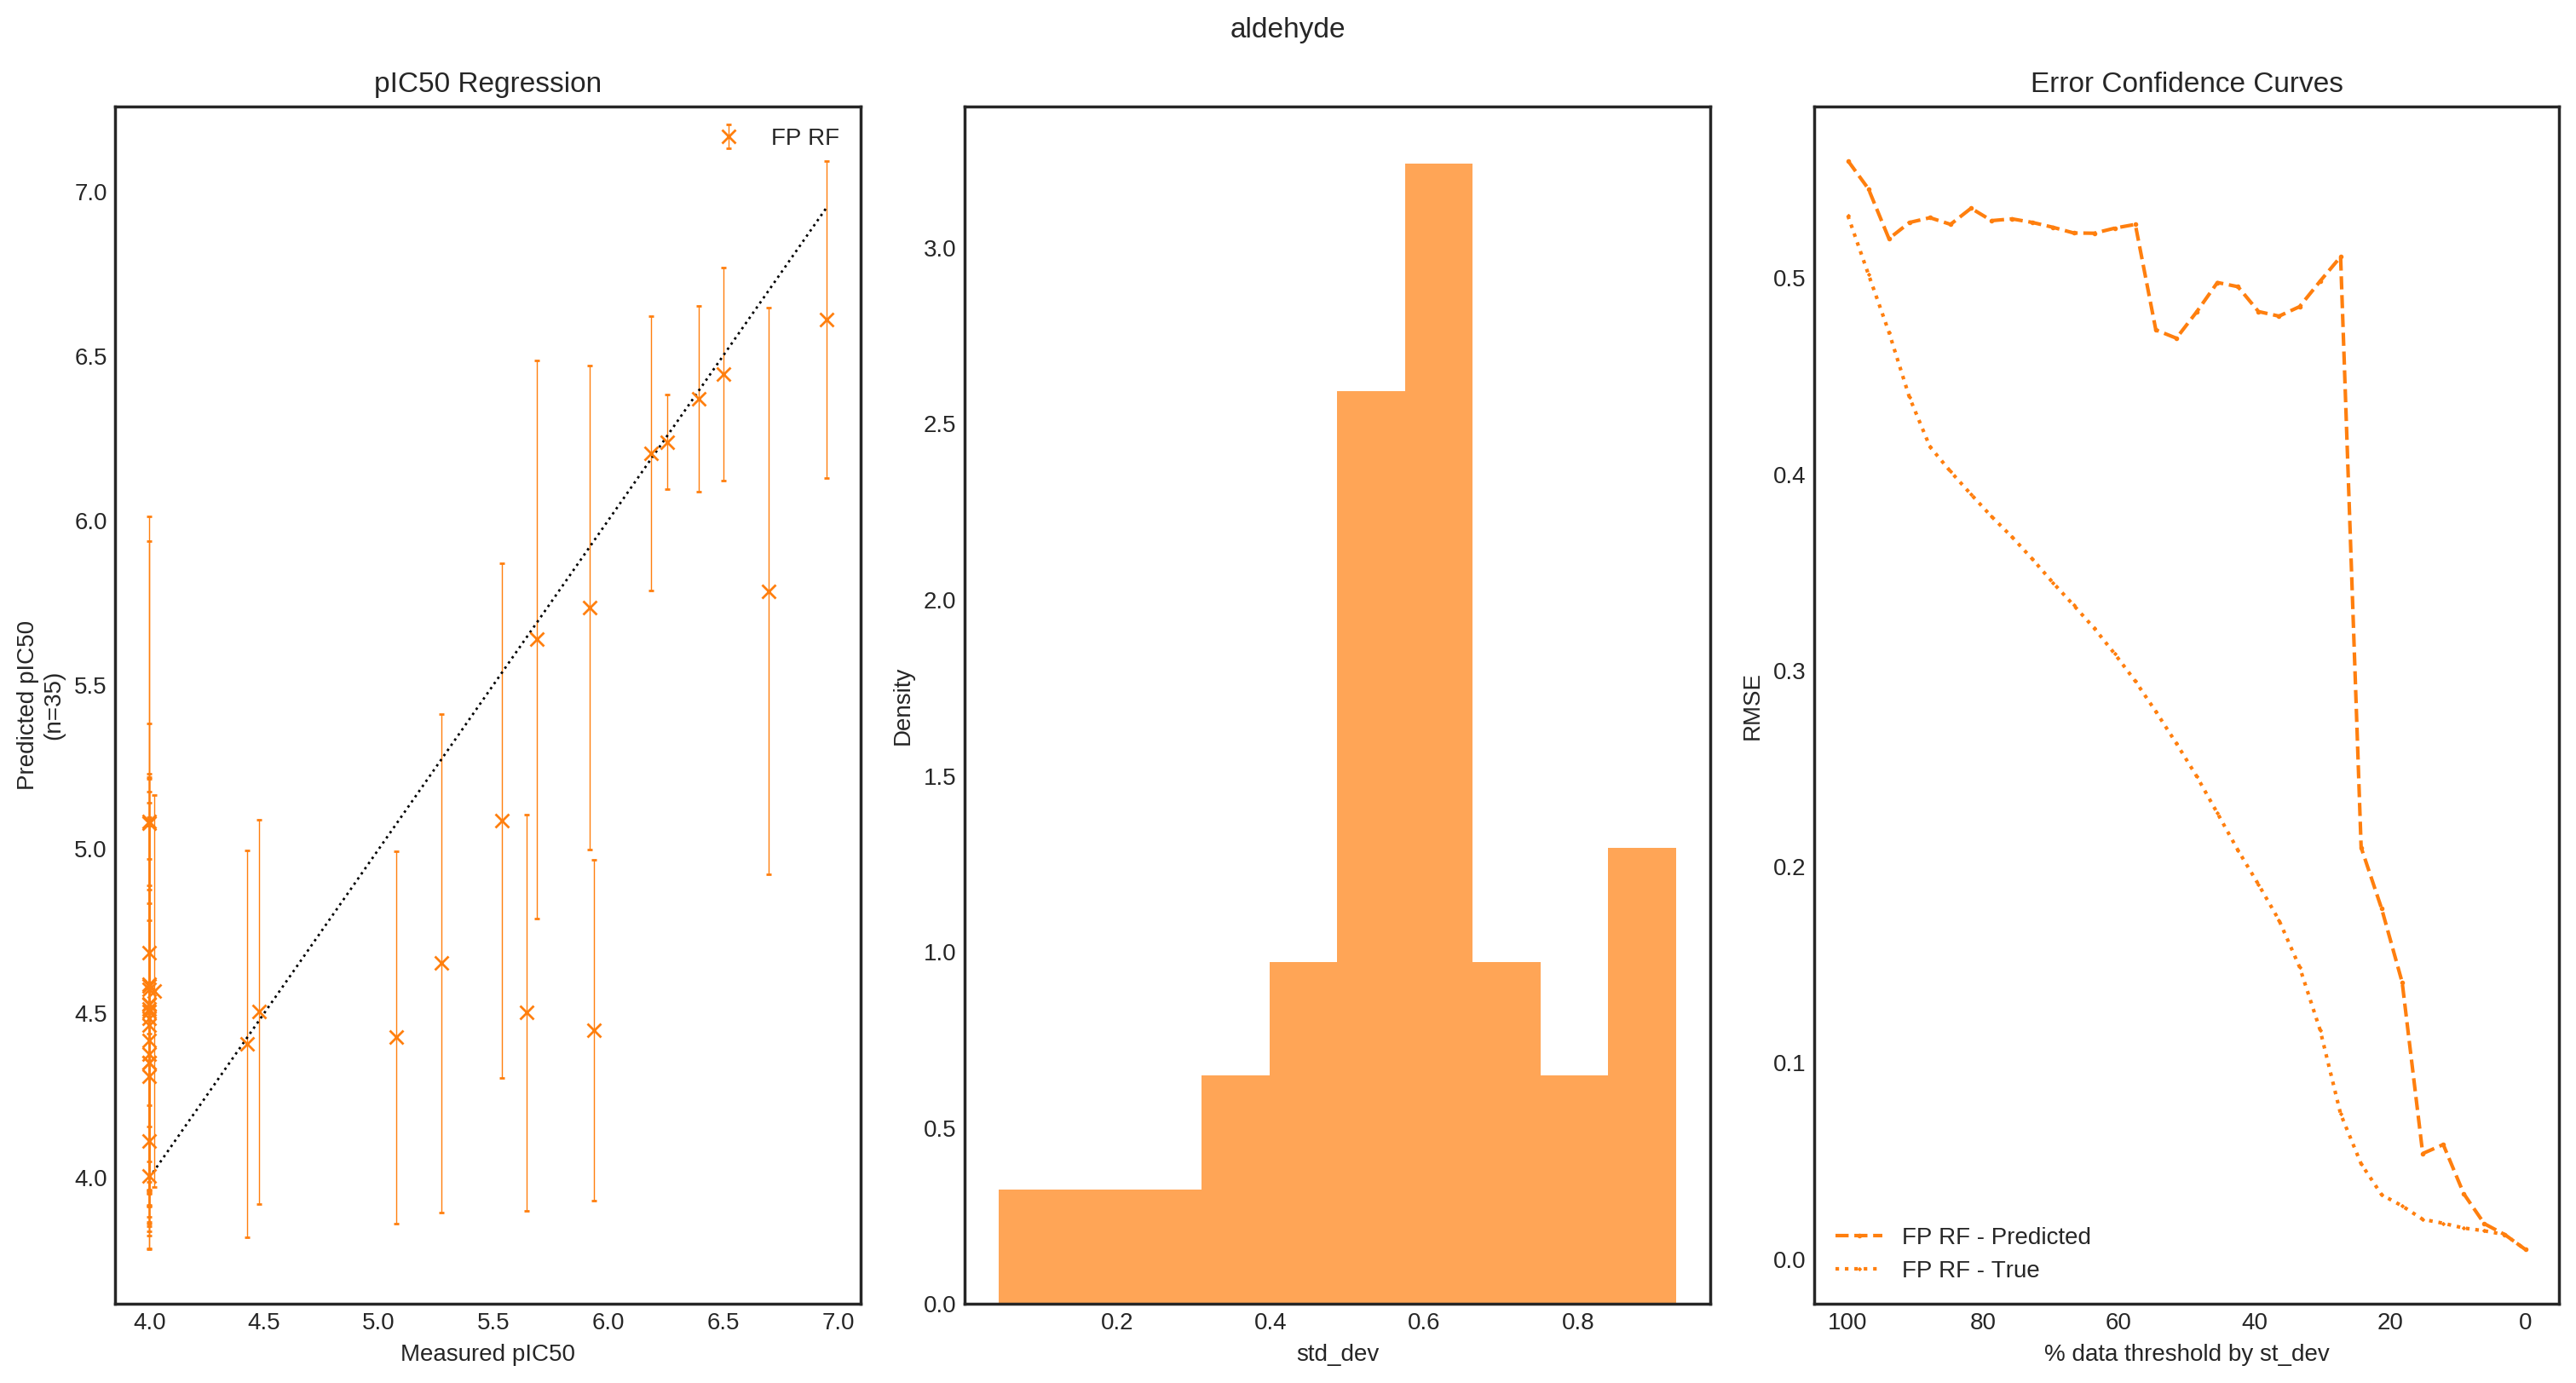

{'n_estimators': 1595, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}


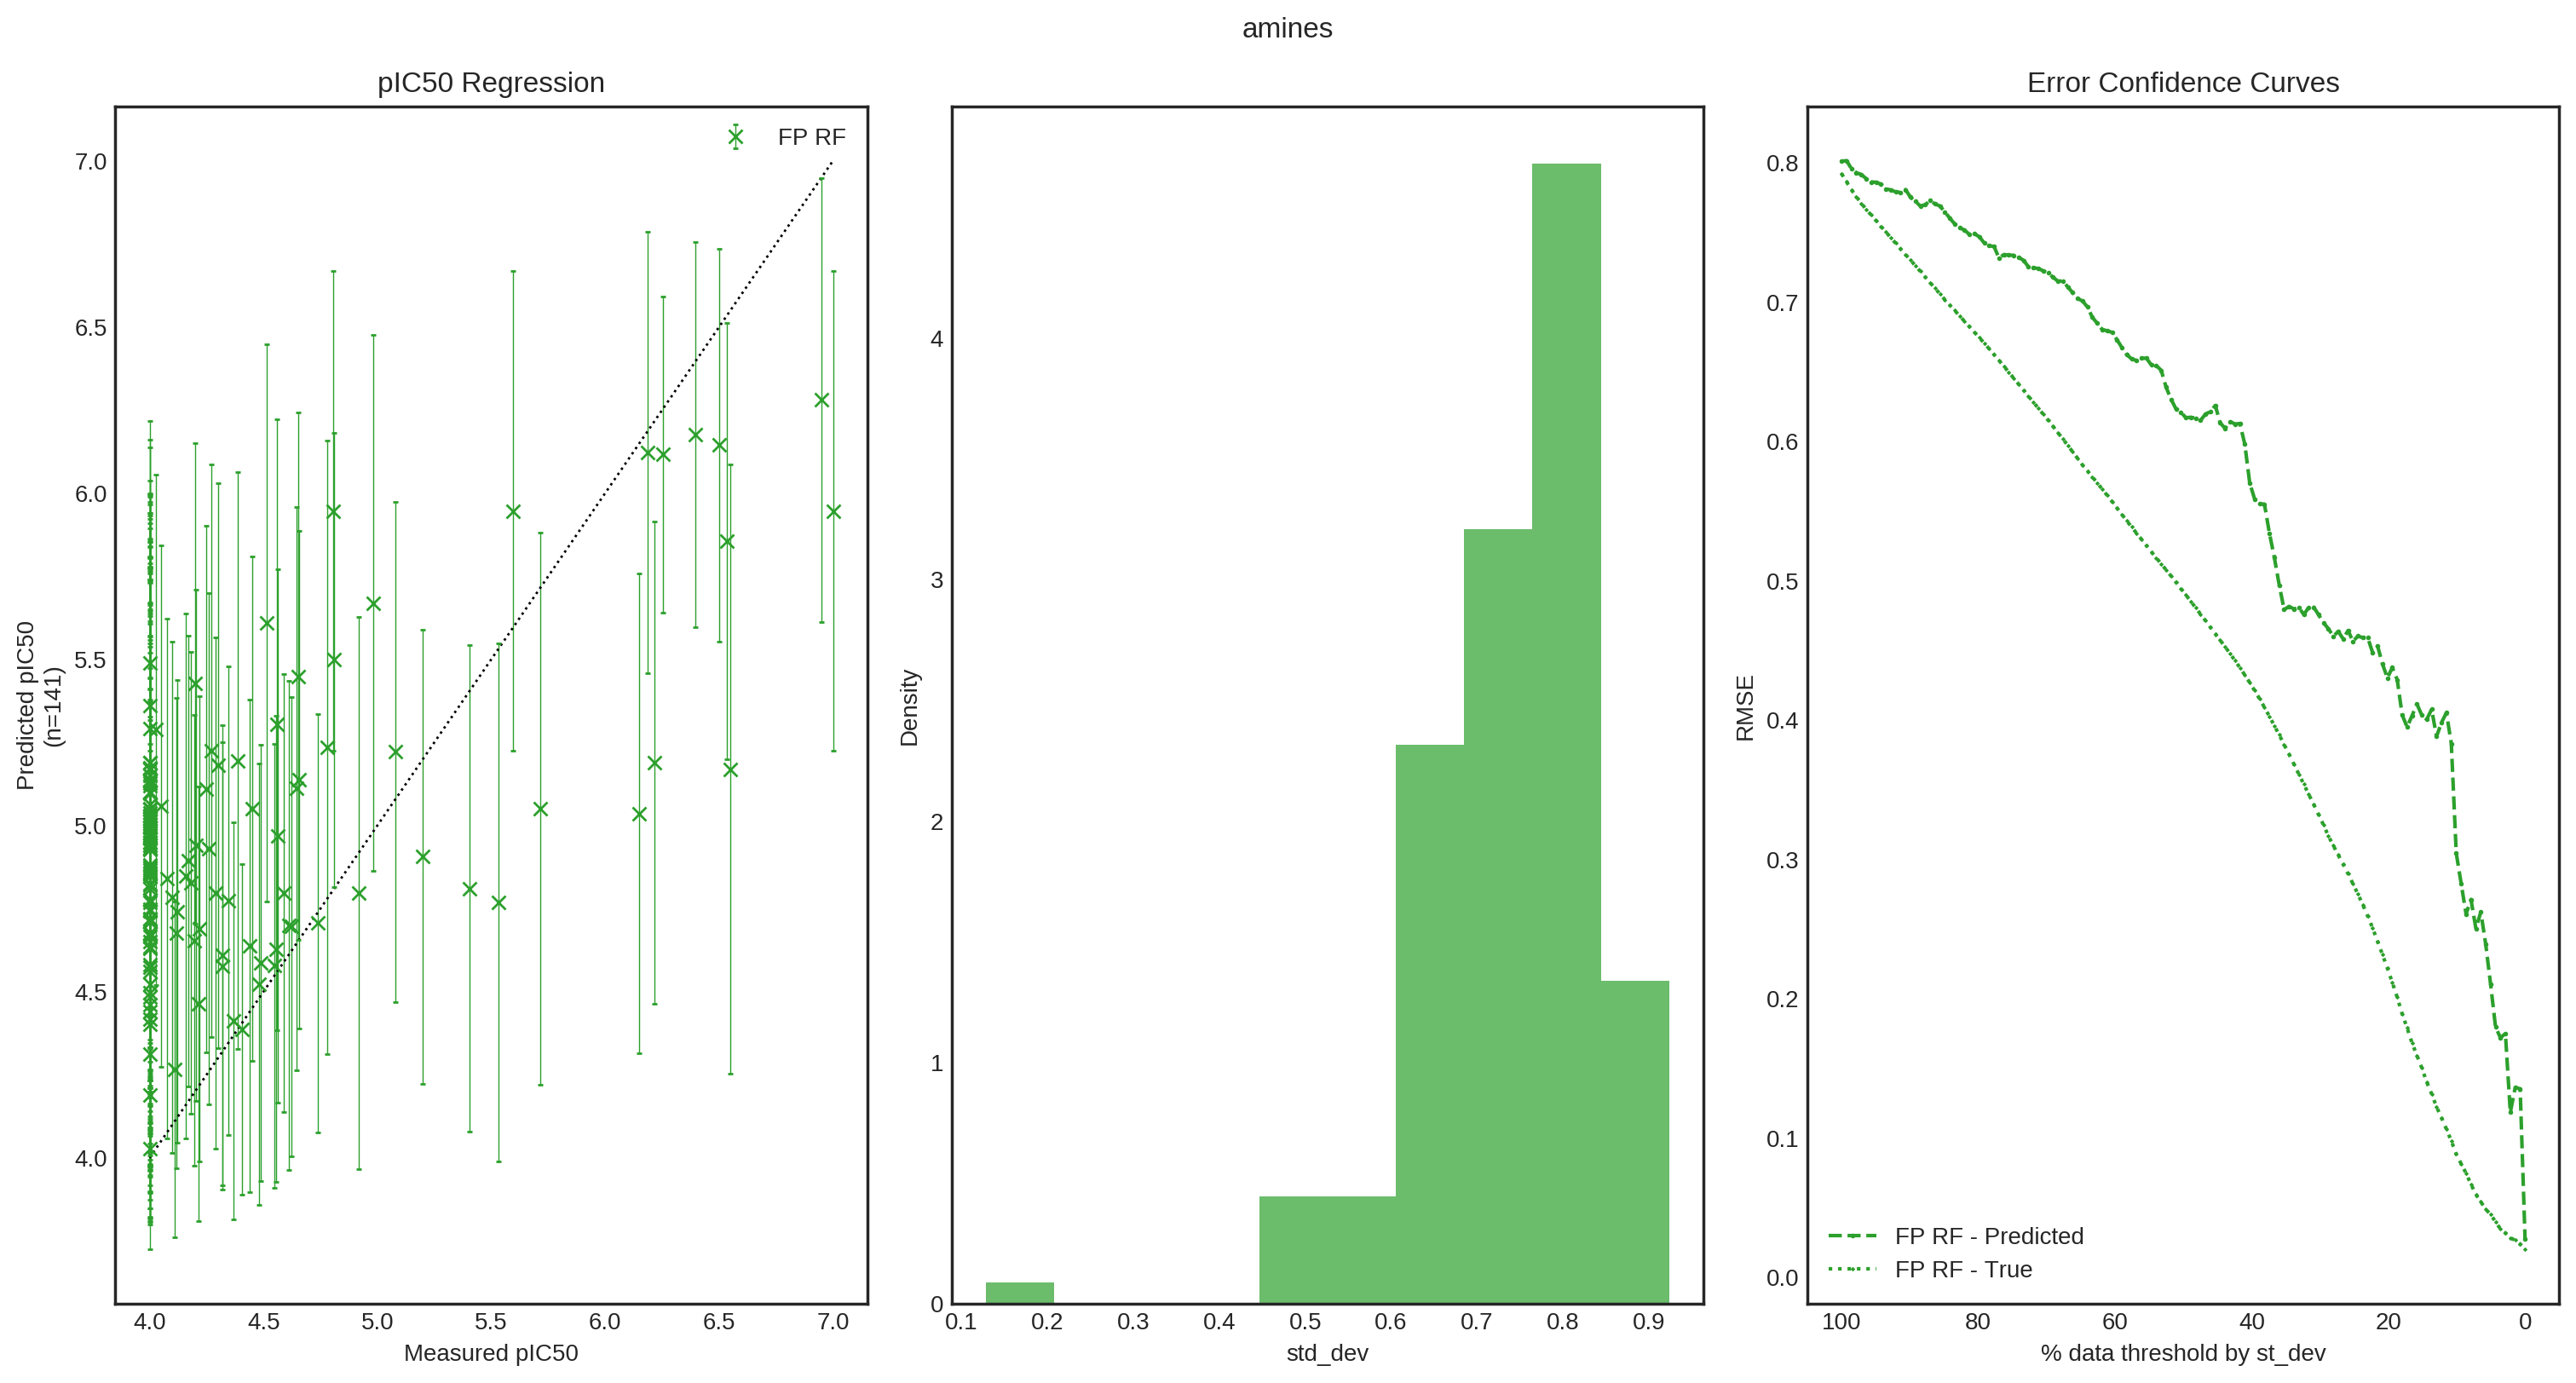

{'n_estimators': 1265, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}


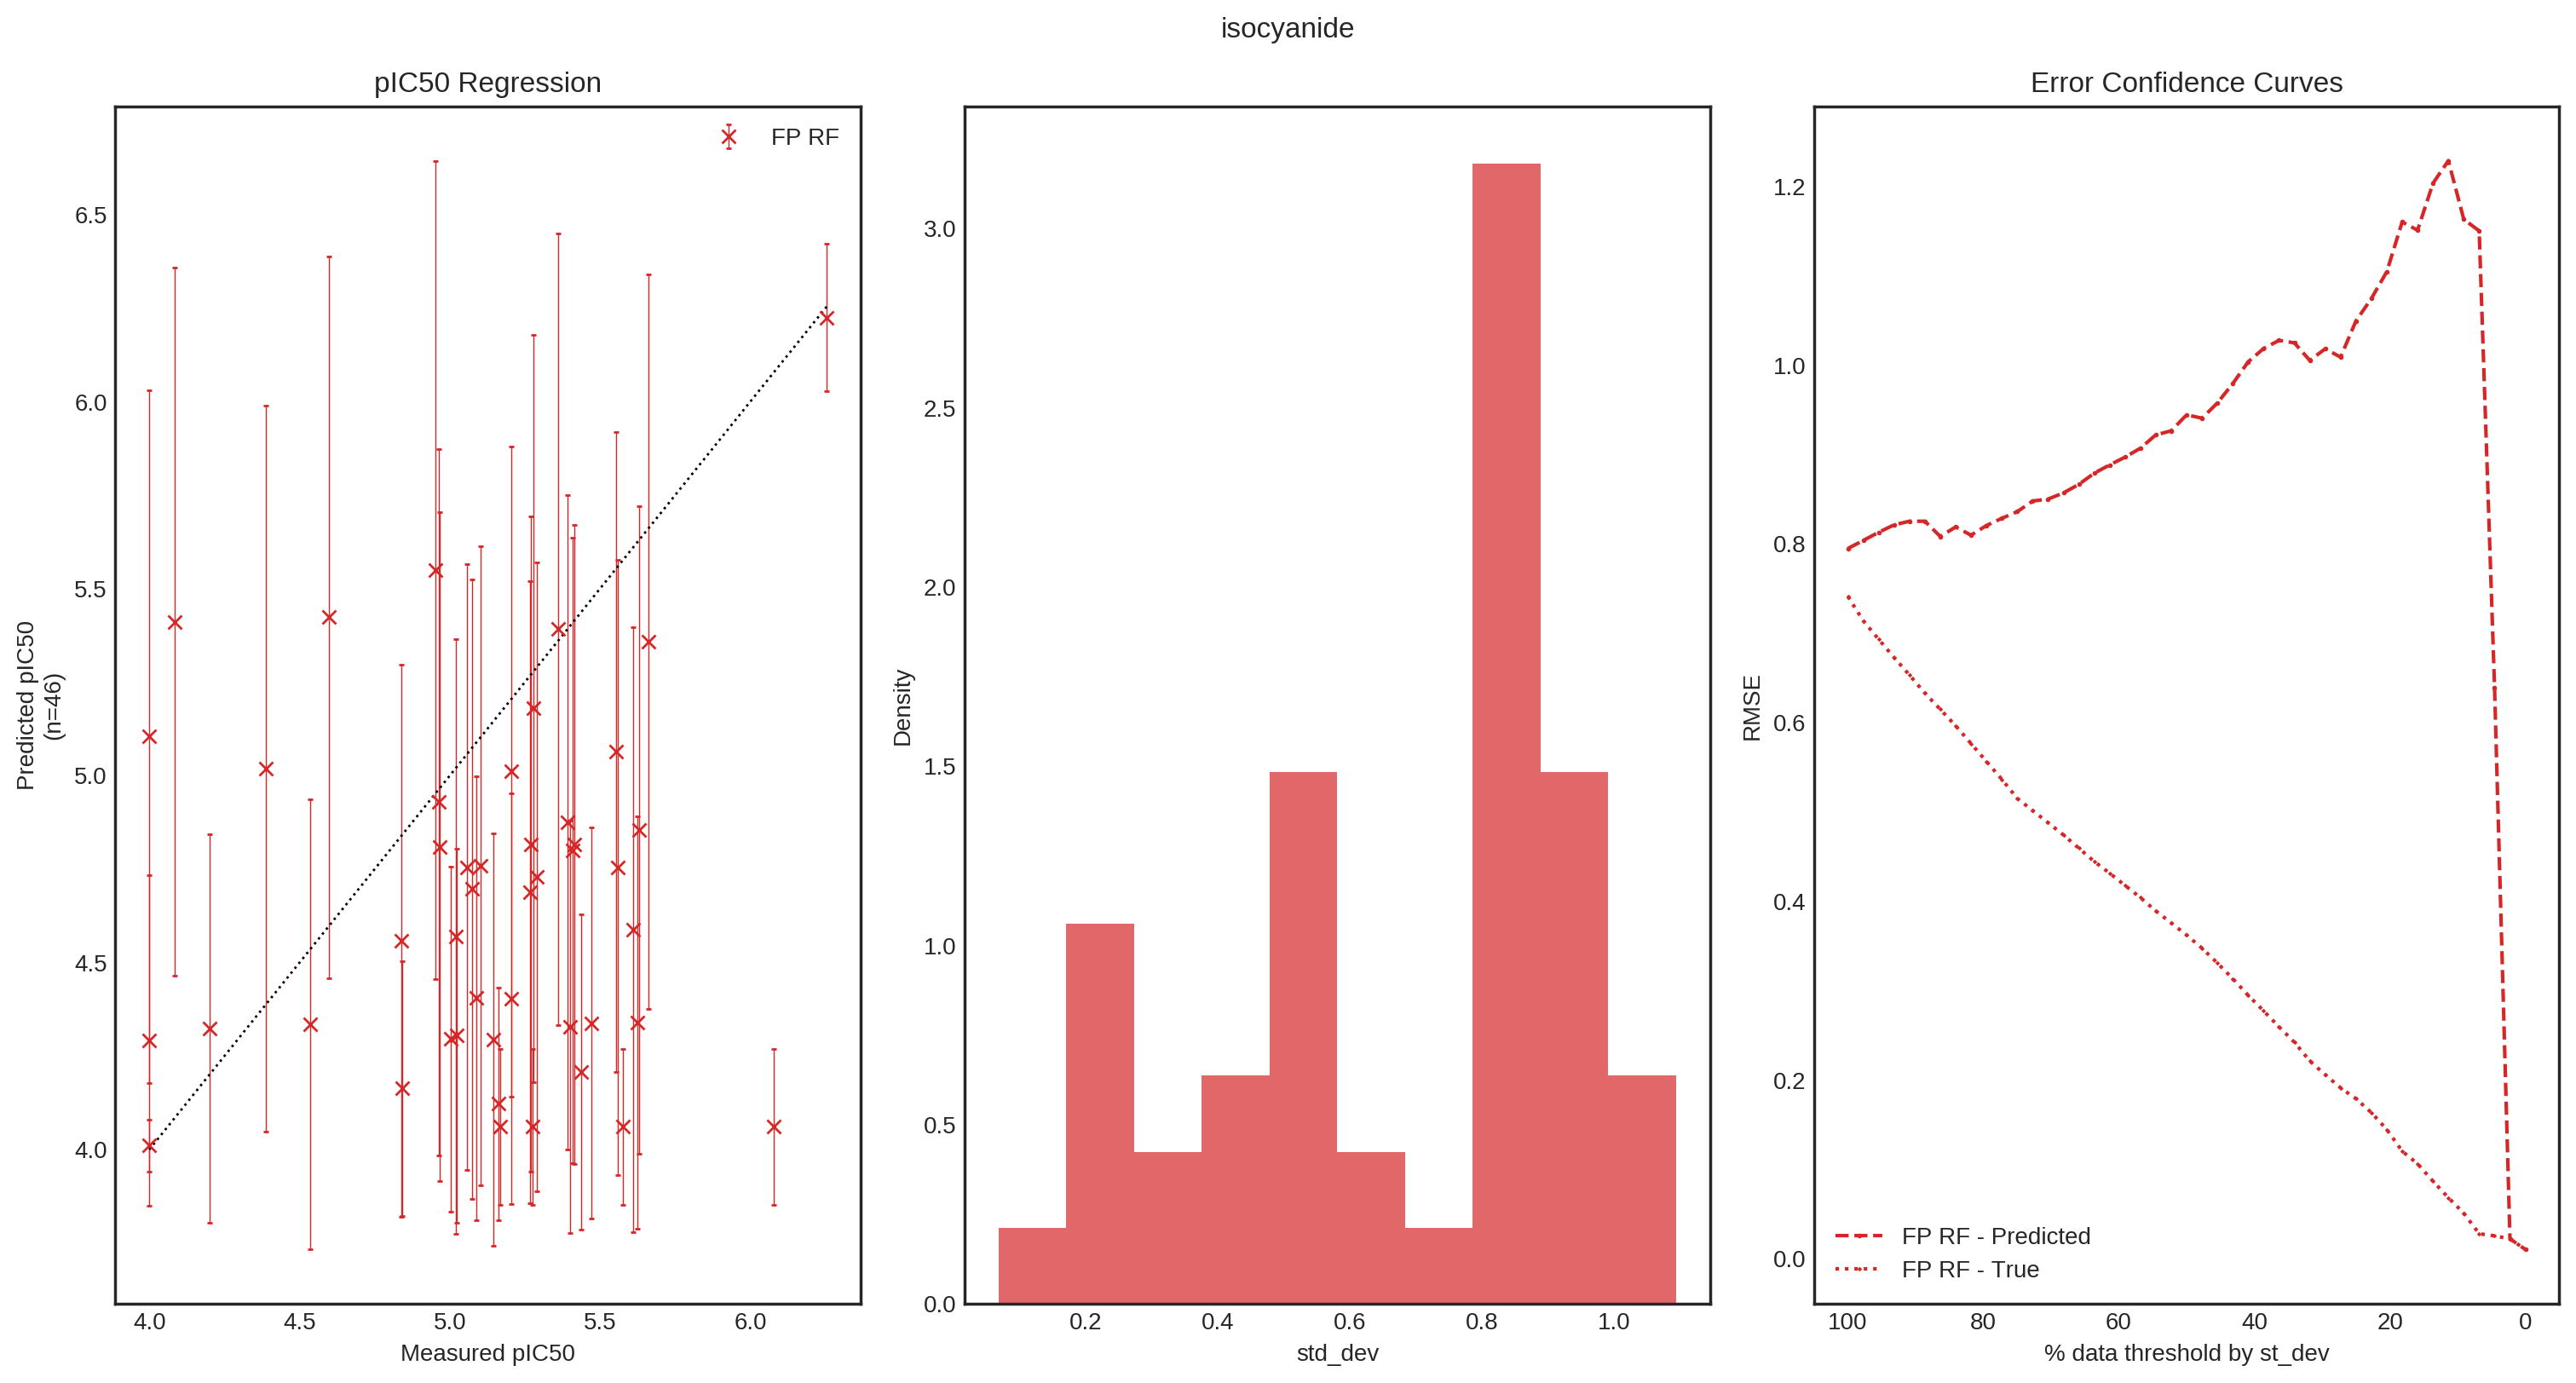

In [13]:
inactive = True
split_names = ['acid', 'aldehyde', 'amines', 'isocyanide']
plt.style.use('seaborn-white')
cmap = plt.get_cmap("tab10")

for i, y_test in enumerate(ys):
    if not inactive:
        X_train_fps_taut = np.concatenate(
            [x[test_inds_list[j]] for j, x in enumerate(xs_taut_train) if i != j])
        y_train = np.concatenate([y[test_inds_list[j]]
                                 for j, y in enumerate(ys) if i != j])

    else:
        X_train_fps_taut = np.concatenate(
            [x for j, x in enumerate(xs_taut_train) if i != j])
        y_train = np.concatenate([y for j, y in enumerate(ys) if i != j])

    X_test_fps_taut = xs_taut_train[i]

    rf_fps_taut = fit_forest(
        X_train_fps_taut, y_train.flatten(), uncertain=True)

    preds_fps, var_fps = rf_fps_taut.predict(X_test_fps_taut, no_var=False)

    pred_list = [preds_fps]
    var_list = [var_fps]
    model_names = ['FP RF']
    
    fig, axs = plt.subplots(figsize=(15, 8),
        nrows=1, ncols=3, dpi=200, constrained_layout=True)
    axs[0].plot([np.amin(y_test), np.amax(y_test)], [
                np.amin(y_test), np.amax(y_test)], 'k:', lw=1)

    for n, preds in enumerate(pred_list):
        axs[0].errorbar(y_test, preds, label=model_names[n], yerr=np.sqrt(var_list[n]), 
        linestyle='', marker='x', markersize=6, capsize=1, elinewidth=0.5, color=cmap(i))
        axs[1].hist(np.sqrt(var_list[n]), label=model_names[n],
                    density=True, alpha=0.7, histtype='barstacked', color=cmap(i))
        error_curve(y_test, preds, var_list[n], ax=axs[2], name=model_names[n], color=cmap(i)) 
    axs[2].invert_xaxis()
    axs[0].set_title('pIC50 Regression')
    axs[0].set_xlabel('Measured pIC50')
    axs[0].set_ylabel(
        'Predicted pIC50\n(n={})'.format(len(y_test)))
    axs[0].legend()

    axs[1].set_ylabel('Density')
    axs[1].set_xlabel('std_dev')
    plt.suptitle(split_names[i])
    plt.show()  


# Running predictions on new datasets

In [6]:
print('Fitting RF models')
rf_taut = fit_forest(np.concatenate(xs_taut), np.concatenate(ys).flatten())
rf_old = fit_forest(np.concatenate(xs_old), np.concatenate(ys).flatten())

old_model='/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
taut_model='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

def run_prediction(path, model, load_name, savename=None, canon=False):

    df_score = pd.read_csv(path, usecols=['SMILES'])
    if canon:
        df_score['SMILES'] = canon_tautomers(df_score['SMILES']) # already done so just save some time lmao

    x_new = gen_fps(df_score, load_name=load_name)

    preds = model.predict(x_new)

    df_score['predicted_pIC50'] = preds
    # df_score = df_score.sort_values(by='predicted_pIC50', ascending=False)

    if savename:
        df_score.to_csv(savename, index=False)
    return df_score

# print('Running Tautomer predictions...')
# df_p4 = run_prediction('../to_score/p4_picks.csv', model=rf_taut, load_name=taut_model, canon=True)
# df_p41 = run_prediction('../to_score/p4_picks1.csv', model=rf_taut, load_name=taut_model, canon=True)
# df_amines = run_prediction('../to_score/amines_product_to_score.csv', model=rf_taut, load_name=taut_model, canon=True)

# df_p4['df'] = 'p4_picks'
# df_p41['df'] = 'p4_picks1'
# df_amines['df'] = 'amines_product'
# df_taut = pd.concat([df_p4, df_p41, df_amines])
# df_taut.to_csv('../to_score/df_taut.csv', index=False)

# print('Running old model predictions...')
# df_p4 = run_prediction('../to_score/p4_picks.csv', model=rf_old, load_name=old_model)
# df_p41 = run_prediction('../to_score/p4_picks1.csv', model=rf_old, load_name=old_model)
# df_amines = run_prediction('../to_score/amines_product_to_score.csv', model=rf_old, load_name=old_model)

# df_p4['df'] = 'p4_picks'
# df_p41['df'] = 'p4_picks1'
# df_amines['df'] = 'amines_product'

# df_old = pd.concat([df_p4, df_p41, df_amines])
# df_old.to_csv('../to_score/df_old.csv', index=False)


Fitting RF models


## Active learning strategy

In [29]:
# Train model

def run_prediction(path, model, load_name, savename=None, canon=False, uncertain=True):

    df_score = pd.read_csv(path, usecols=['SMILES'])
    if canon:
        df_score['SMILES'] = canon_tautomers(df_score['SMILES']) # already done so just save some time lmao

    x_new = gen_fps(df_score, load_name=load_name)

    if uncertain:
        preds, var = model.predict(x_new, no_var=False)
        df_score['predicted_var'] = var
    else:
        preds = model.predict(x_new)

    df_score['predicted_pIC50'] = preds
    # df_score = df_score.sort_values(by='predicted_pIC50', ascending=False)

    if savename:
        df_score.to_csv(savename, index=False)
    return df_score
    
inactive = True
taut_model = '/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

if not inactive:
    X_train_fps_taut = np.concatenate(
        [x[test_inds_list[j]] for j, x in enumerate(xs_taut_train) ])
    y_train = np.concatenate([y[test_inds_list[j]]
                                for j, y in enumerate(ys)])

else:
    X_train_fps_taut = np.concatenate([x for  x in xs_taut_train])
    y_train = np.concatenate([y for y in ys ])

rf_fps_taut = fit_forest(
    X_train_fps_taut, y_train.flatten(), uncertain=True)


# print('Running Tautomer predictions...')
df_p4 = run_prediction('../to_score/p4_picks.csv', model=rf_fps_taut, load_name=taut_model, canon=True)
df_p41 = run_prediction('../to_score/p4_picks1.csv',
                        model=rf_fps_taut, load_name=taut_model, canon=True)
df_amines = run_prediction('../to_score/amines_product_to_score.csv',
                           model=rf_fps_taut, load_name=taut_model, canon=True)

df_p4['df'] = 'p4_picks'
df_p41['df'] = 'p4_picks1'
df_amines['df'] = 'amines_product'
df_taut = pd.concat([df_p4, df_p41, df_amines])
df_taut.to_csv('../to_score/df_uncertain.csv', index=False)


  1%|          | 2/198 [00:00<00:30,  6.48it/s]

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}


100%|██████████| 198/198 [00:33<00:00,  5.93it/s]


Shape of MPNN graph features: (198, 64)


100%|██████████| 344/344 [00:45<00:00,  7.61it/s]


Shape of MPNN graph features: (344, 64)


100%|██████████| 4008/4008 [05:56<00:00, 11.25it/s]


Shape of MPNN graph features: (4008, 64)


In [ ]:
# Define strategies
import mols2grid
from rdkit.Chem import rdFMCS
from scipy.stats import norm

def pick_n(df_score, strat='greedy', N=20, xi=0.01):
    df_pick = df_score.copy().drop_duplicates(subset='SMILES')
    if strat=='greedy':
        return df_pick.nlargest(N, columns='predicted_pIC50').copy()
    elif strat=='EI':
        pred = df_pick['predicted_pIC50']
        y_std = df_pick['predicted_var']
        y_best = np.amax(pred)

        with np.errstate(divide='warn'):
            imp = pred - y_best - xi
            Z =  imp/y_std
            df_pick['EI'] = imp*norm.cdf(Z) + y_std*norm.pdf(Z)
        return  df_pick.nlargest(N, columns='EI').copy()
    else:
        raise Exception('Unsupported selection strategy provided')

def display_topn(df, N=20, strat='greedy'):
    df_best = pick_n(df, N=N, strat=strat)

    mols = [MolFromSmiles(smi) for smi in df_best['SMILES']]
    mcs = rdFMCS.FindMCS(mols)
    mcs_query = Chem.MolFromSmarts(mcs.smartsString)
    AllChem.Compute2DCoords(mcs_query)
    for m in mols:
        AllChem.GenerateDepictionMatching2DStructure(m, mcs_query)
    df_best['mols'] = mols

    return df_best, mols2grid.display(df_best,
                    mol_col='mols',
                    smiles_col='SMILES',
                    subset=['img', 'predicted_pIC50', 'predicted_var'],
                    transform={"predicted_pIC50": lambda x: f"y_pred: {x:.3f}",
                               "predicted_var": lambda x: f"y_var: {x:.3f}"},
                    tooltip=["SMILES"],
                    useSVG=True,
                    use_coords=True,
                    selection=True,
                    n_rows=5,
                    size=(240, 260),
                    width='85%')

df_taut = pd.read_csv('../to_score/df_uncertain.csv')
df_p4 = df_taut[df_taut['df'] == 'p4_picks']
df_p41 = df_taut[df_taut['df'] == 'p4_pick1']
df_amines = df_taut[df_taut['df'] == 'amines_product']

display(Markdown("<b>Greedy Selection</b>"))

df_greed, grid = display_topn(df_amines, strat='greedy')
display(grid)

display(Markdown("<b>EI Selection</b>"))
df_EI, grid = display_topn(df_amines, strat='EI')

print('% overlapping between greedy and EI selection: {:.1f}%'.format(
    100*len(np.intersect1d(df_EI['SMILES'], (df_greed['SMILES'])))/len(df_EI['SMILES'])))

display(grid)
# display(df_amines)


In [16]:
df_train = pd.concat([df for df in dfs_taut])

df_taut = pd.read_csv('../to_score/df_uncertain.csv')
df_taut = df_taut[~df_taut['SMILES'].isin(df_train['SMILES'])]

df_p4 = df_taut[df_taut['df'] == 'p4_picks']
df_p41 = df_taut[df_taut['df'] == 'p4_picks1']
df_amines = df_taut[df_taut['df'] == 'amines_product']

display(Markdown("<b>Greedy Selection - p4</b>"))
print('% of df_p4 in training set: {:.1f}%'.format(
    100*len(np.intersect1d(df_train['SMILES'], (df_p4['SMILES'])))/len(df_p4['SMILES'])))
df_p4_greed, grid = display_topn(df_p4, N=50, strat='greedy')
# display(grid)
df_p4_greed[['SMILES']].to_csv('../to_score/p4_picks_top50.csv', index=False)

display(Markdown("<b>Greedy Selection - p41</b>"))
print('% of df_p41 in training set: {:.1f}%'.format(
    100*len(np.intersect1d(df_train['SMILES'], (df_p41['SMILES'])))/len(df_p41['SMILES'])))
df_p41_greed, grid = display_topn(df_p41, N=50, strat='greedy')
# display(grid)
df_p41_greed[['SMILES']].to_csv('../to_score/p4_picks1_top50.csv', index=False)

display(Markdown("<b>Greedy Selection - amines</b>"))
print('% of df_amines in training set: {:.1f}%'.format(
    100*len(np.intersect1d(df_train['SMILES'], (df_amines['SMILES'])))/len(df_amines['SMILES'])))
df_amines_greed, grid = display_topn(df_amines, N=50, strat='greedy')
# display(grid)
df_amines_greed[['SMILES']].to_csv('../to_score/amine_product_top50.csv', index=False)


<b>Greedy Selection - p4</b>

% of df_p4 in training set: 0.0%


<b>Greedy Selection - p41</b>

% of df_p41 in training set: 0.0%


<b>Greedy Selection - amines</b>

% of df_amines in training set: 0.0%


### Ensemble predictions

In [8]:
print('Fitting RF models')

n_models = 10

old_model='/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
taut_model='/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

dfs_p4 = []
dfs_p41 = []
dfs_amines = []
for n in tqdm(range(n_models)):
    rf_taut = fit_forest(np.concatenate(xs_taut), np.concatenate(ys).flatten())
    dfs_p4.append(run_prediction('../to_score/p4_picks_scored_taut.csv', model=rf_taut, load_name=taut_model))
    dfs_p41.append(run_prediction('../to_score/p4_picks1_scored_taut.csv', model=rf_taut, load_name=taut_model))
    dfs_amines.append(run_prediction('../to_score/amines_product_scored_taut.csv', model=rf_taut, load_name=taut_model))

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting RF models
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 10%|█         | 1/10 [00:27<04:04, 27.17s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 20%|██        | 2/10 [00:49<03:15, 24.48s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 30%|███       | 3/10 [01:15<02:54, 24.93s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 40%|████      | 4/10 [01:41<02:33, 25.53s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 50%|█████     | 5/10 [02:09<02:11, 26.30s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 60%|██████    | 6/10 [02:34<01:44, 26.06s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 70%|███████   | 7/10 [03:00<01:17, 25.99s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


 80%|████████  | 8/10 [03:26<00:51, 25.87s/it]

Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)


 90%|█████████ | 9/10 [03:52<00:26, 26.09s/it]

Shape of MPNN graph features: (4008, 64)
Shape of MPNN graph features: (198, 64)
Shape of MPNN graph features: (344, 64)
Shape of MPNN graph features: (4008, 64)


100%|██████████| 10/10 [04:21<00:00, 26.20s/it]


In [ ]:
from functools import reduce

scores = []
for n in range(n_models):
    score_name = 'score_'+str(n)
    dfs_p4[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    dfs_p41[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    dfs_amines[n].rename(columns={'predicted_pIC50': score_name}, inplace=True)
    scores.append(score_name)

def merge_ensemble(dfs):
    df_merged = pd.concat(dfs, axis=1)
    df_merged = df_merged.loc[:,~df_merged.columns.duplicated()]
    df_merged['pred_mean'] = np.mean(df_merged[scores], axis=1)
    df_merged['pred_std'] = np.std(df_merged[scores], axis=1)
    return df_merged[['SMILES', 'pred_mean', 'pred_std']].sort_values(by='pred_mean', ascending=False)

df_p4_merged = merge_ensemble(dfs_p4)
df_p41_merged = merge_ensemble(dfs_p41)
df_amine_merged = merge_ensemble(dfs_amines)

df_p4_merged.to_csv('../to_score/p4_picks_scored_ensemble.csv', index=False)
df_p41_merged.to_csv('../to_score/p4_picks1_scored_ensemble.csv', index=False)
df_amine_merged.to_csv('../to_score/amines_product_scored_ensemble.csv', index=False)

## Visualisation

Text(0.5, 0.98, 'Ugi pIC50 model comparison')

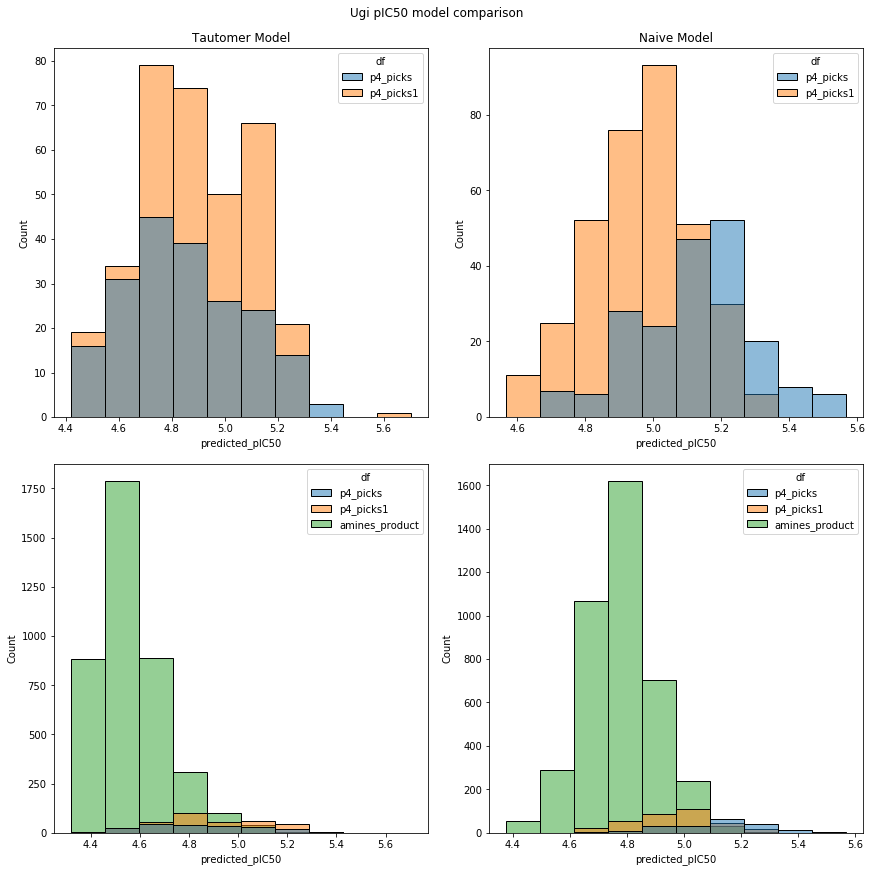

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12), constrained_layout=True)
sns.histplot(ax=axes[0,0], data = df_taut[df_taut['df']!='amines_product'], x="predicted_pIC50", hue="df", bins=10)
sns.histplot(ax=axes[0,1], data = df_old[df_old['df']!='amines_product'], x="predicted_pIC50", hue="df", bins=10)
axes[0,0].set_title('Tautomer Model')
axes[0,1].set_title('Naive Model')

sns.histplot(ax=axes[1,0], data = df_taut, x="predicted_pIC50", hue="df", bins=10)
sns.histplot(ax=axes[1,1], data = df_old, x="predicted_pIC50", hue="df", bins=10)
plt.suptitle('Ugi pIC50 model comparison')
# plt.title('pIC50 predicitions from tautomer model')

### Top-N amines from new model

In [ ]:
import mols2grid
from rdkit.Chem import rdFMCS

df_taut = pd.read_csv('../to_score/df_taut.csv')
df_old = pd.read_csv('../to_score/df_old.csv')
df_amines = df_taut[df_taut['df']=='amines_product']
df_best = df_amines.nlargest(20, columns='predicted_pIC50')

mols = [MolFromSmiles(smi) for smi in df_best['SMILES']]
mcs=rdFMCS.FindMCS(mols)
mcs_query = Chem.MolFromSmarts(mcs.smartsString)            
AllChem.Compute2DCoords(mcs_query)
for m in mols: 
    AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
df_best['mols'] = mols

mols2grid.display(df_best,
                  mol_col='mols',
                  smiles_col='SMILES',
                  subset=['img','predicted_pIC50'],
                  transform={"predicted_pIC50": lambda x: f"y_pred: {x:.3f}"},
                  tooltip=["SMILES"],
                  useSVG=True,
                  use_coords=True,
                  selection=False,
                  n_rows=5,
                  size=(240,260),
                  width='85%')


### Mols with biggest difference

In [ ]:
df_both = df_taut.merge(df_old, how='inner', left_index=True, right_index=True)
df_both = df_both[df_both['df_x']=='amines_product']
df_both = df_both.rename(columns={'predicted_pIC50_x': 'pred_new',
                                  'predicted_pIC50_y': 'pred_old'})
df_both['diff'] = df_both['pred_new'] - df_both['pred_old']
df_both['abs_diff'] = np.abs(df_both['diff'])

# df_diff = df_both
df_diff = df_both.nlargest(100, columns='diff')
df_diff = df_both.nsmallest(100, columns='diff')

mols = [MolFromSmiles(smi) for smi in df_diff['SMILES_x']]
mcs=rdFMCS.FindMCS(mols)
mcs_query = Chem.MolFromSmarts(mcs.smartsString)            
AllChem.Compute2DCoords(mcs_query)
for m in mols: 
    AllChem.GenerateDepictionMatching2DStructure(m,mcs_query)
df_diff['mols'] = mols

mols2grid.display(df_diff,
                  mol_col='mols',
                  smiles_col='SMILES_x',
                  subset=['img','diff'],
                  transform={"diff": lambda x: f"Δ y_pred: {x:.3f}"},
                  tooltip=["SMILES_x"],
                  useSVG=True,
                  use_coords=True,
                  selection=False,
                  n_rows=5,
                  size=(240,260),
                  width='85%')


In [7]:
# Alpha's test & searching for molecules

test_mols = [   'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC(C)C)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC5CCC5)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(C(C)(C)C)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(CC5COC5)cc4',
                'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(C5COC5)cc4']
test_df = pd.DataFrame(test_mols, columns=['SMILES'])
print(test_df)

# search='CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1cscn1'
search = 'CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1c[nH]cn1'
# search = 'O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=O)c4ccc(OC(C)C)cc4'
df_all = pd.concat(dfs_taut)
print(df_all[df_all['SMILES'].isin([search])])

                                              SMILES
0  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
1  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
2  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
3  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...
4  O=C(c1[nH]cnc1)N(C(c2cnccc2)C(NCCc3cc(F)ccc3)=...


4th Apr - new compounds to test from Alpha

In [4]:
new_test_mols = ['O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4',
                 'O=C(NCCc1sncc1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3ncoc3)=O)c4ccc(C(C)(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(OC(C)C)cc4',
                 'O=C(NCCC1=CC(F)=C(OC)C=C1)C(c2cnccc2)N(C(c3nc[nH]c3)=O)c4ccc(C(C)(C)C)cc4',
                 ]

test_df = pd.DataFrame(new_test_mols, columns=['SMILES'])


Run predictions on new molecules

In [7]:
from tqdm import tqdm
from dock2hit.model_fitting import fit_forest

def merge_ensemble_of_score_dfs(list_of_dfs):
    df_merged = pd.concat(list_of_dfs, axis=1)
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
    df_merged['pred_mean'] = np.mean(df_merged[scores], axis=1)
    df_merged['pred_std'] = np.std(df_merged[scores], axis=1)
    return df_merged[['SMILES', 'pred_mean', 'pred_std']].sort_values(by='pred_mean', ascending=False)

def run_prediction_on_dataframe(df, model, load_name, savename=None, canon=False, uncertain=True):

    df_score = df.copy()
    if canon:
        # already done so just save some time lmao
        df_score['SMILES'] = canon_tautomers(df_score['SMILES'])

    x_new = generate_mpnn_fps_from_dataframe(df_score, load_name=load_name)

    if uncertain:
        preds, var = model.predict(x_new, no_var=False)
        df_score['predicted_var'] = var
    else:
        preds = model.predict(x_new)

    df_score['predicted_pIC50'] = preds
    # df_score = df_score.sort_values(by='predicted_pIC50', ascending=False)

    if savename:
        df_score.to_csv(savename, index=False)
    return df_score

print('Fitting RF models')

n_models = 1

old_model = '/rds-d2/user/wjm41/hpc-work/models/ugi_full/model_mol4608000.ckpt'
tautomer_mpnn = '/rds-d2/user/wjm41/hpc-work/models/ugi_taut/model_mol9039221.ckpt'

list_of_score_dfs = []
for n in tqdm(range(n_models)):
    score_name = 'score_'+str(n)
    random_forest_trained_on_all_data = fit_forest(np.vstack(df_all['mpnn_fp'].to_numpy()), df_all['pIC50'].to_numpy())
    df_with_predictions = run_prediction(
        test_df, model=random_forest_trained_on_all_data, load_name=tautomer_mpnn)
    df_with_predictions.rename(
        columns={'predicted_pIC50': score_name}, inplace=True)
    list_of_score_dfs.append(df_with_predictions)
    
df_mean = merge_ensemble_of_score_dfs(list_of_score_dfs)
df_mean

Fitting RF models


KeyboardInterrupt: 